# Code 11: Appendiceal Topics

```{admonition} This is a reference notebook for the book Bayesian Modeling and Computation in Python
:class: tip, dropdown
The textbook is not needed to use or run this code, though the context and explanation is missing from this notebook.

If you'd like a copy it's available
[from the CRC Press](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368)
or from [Amazon](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368).
``

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from scipy.special import binom, betaln

In [2]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300

In [3]:
np.random.seed(14067)

## Probability Background

### Code 11.1

In [4]:
def die():
    outcomes = [1, 2, 3, 4, 5, 6]
    return np.random.choice(outcomes)

die()

6

### Code 11.2

In [5]:
def experiment(N=10):
    sample = [die() for i in range(N)]

    for i in range(1, 7):
        print(f"{i}: {sample.count(i)/N:.2g}")

experiment()

1: 0
2: 0.1
3: 0.3
4: 0
5: 0.2
6: 0.4


In [6]:
a = 1
b = 6
rv = stats.randint(a, b+1)
x = np.arange(1, b+1)

x_pmf = rv.pmf(x)  # evaluate the pmf at the x values
x_cdf = rv.cdf(x)  # evaluate the cdf at the x values
mean, variance = rv.stats(moments="mv")

### Figure 11.17

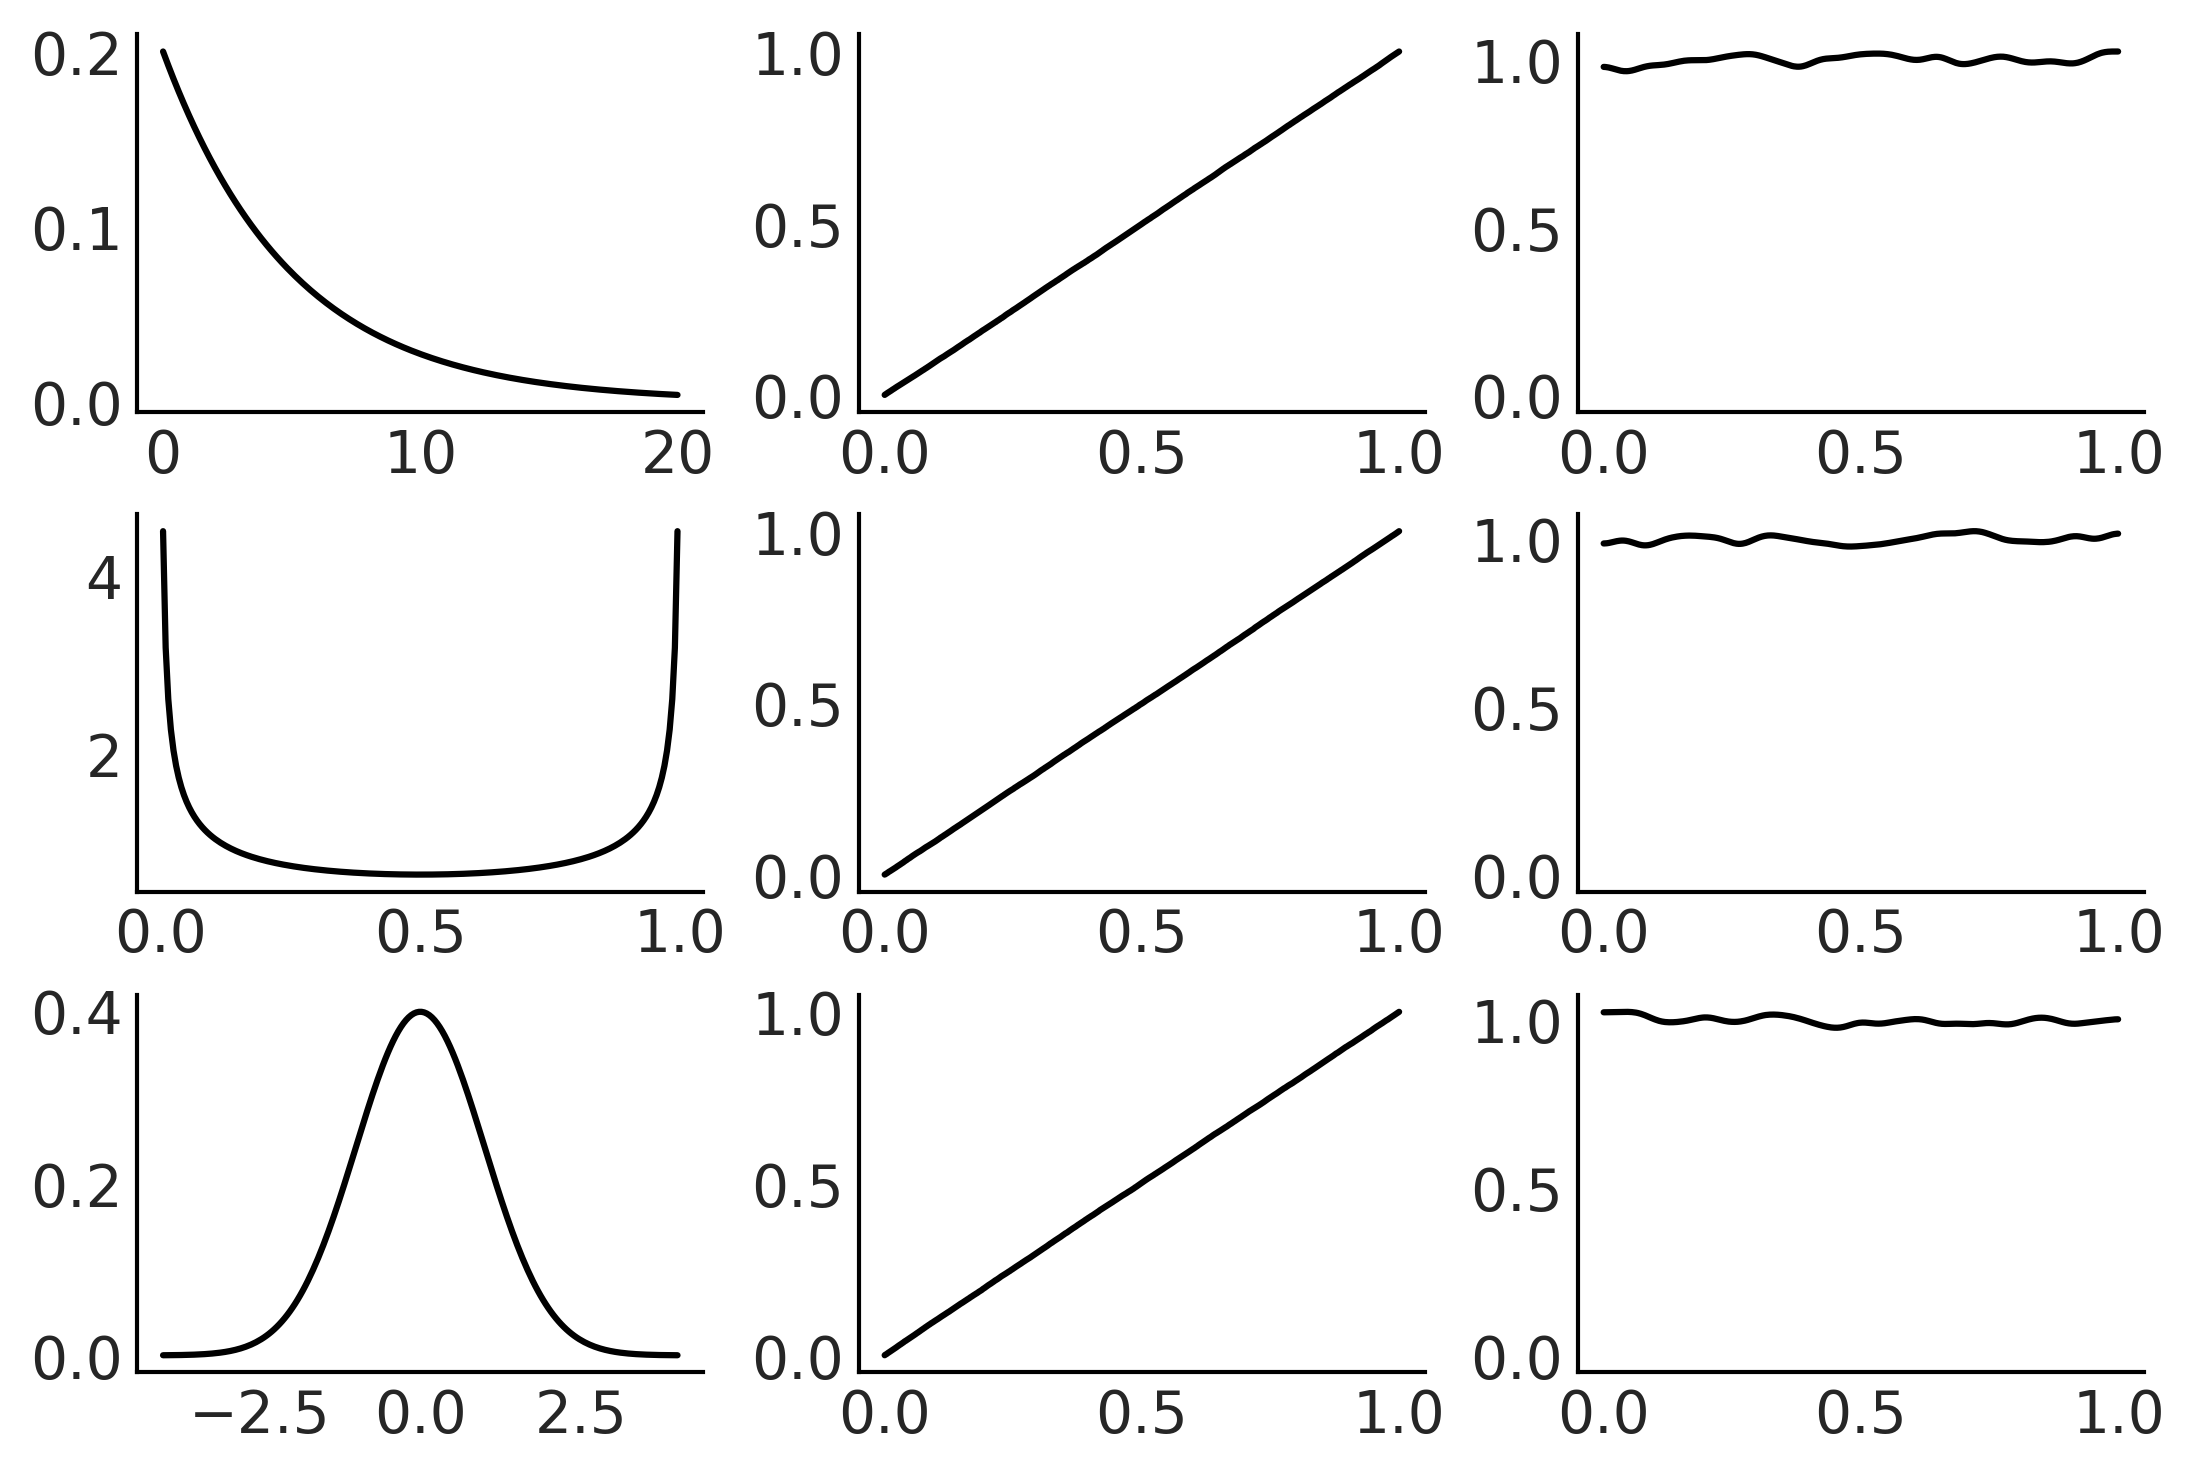

In [7]:
xs = (np.linspace(0, 20, 200), np.linspace(0, 1, 200), np.linspace(-4, 4, 200))
dists = (stats.expon(scale=5), stats.beta(0.5, 0.5), stats.norm(0, 1))


_, ax = plt.subplots(3, 3)

for idx, (dist, x) in enumerate(zip(dists, xs)):
    draws = dist.rvs(100000)
    data = dist.cdf(draws)
    # PDF original distribution
    ax[idx, 0].plot(x, dist.pdf(x))
    # Empirical CDF
    ax[idx, 1].plot(np.sort(data), np.linspace(0, 1, len(data)))
    # Kernel Density Estimation
    az.plot_kde(data, ax=ax[idx, 2])

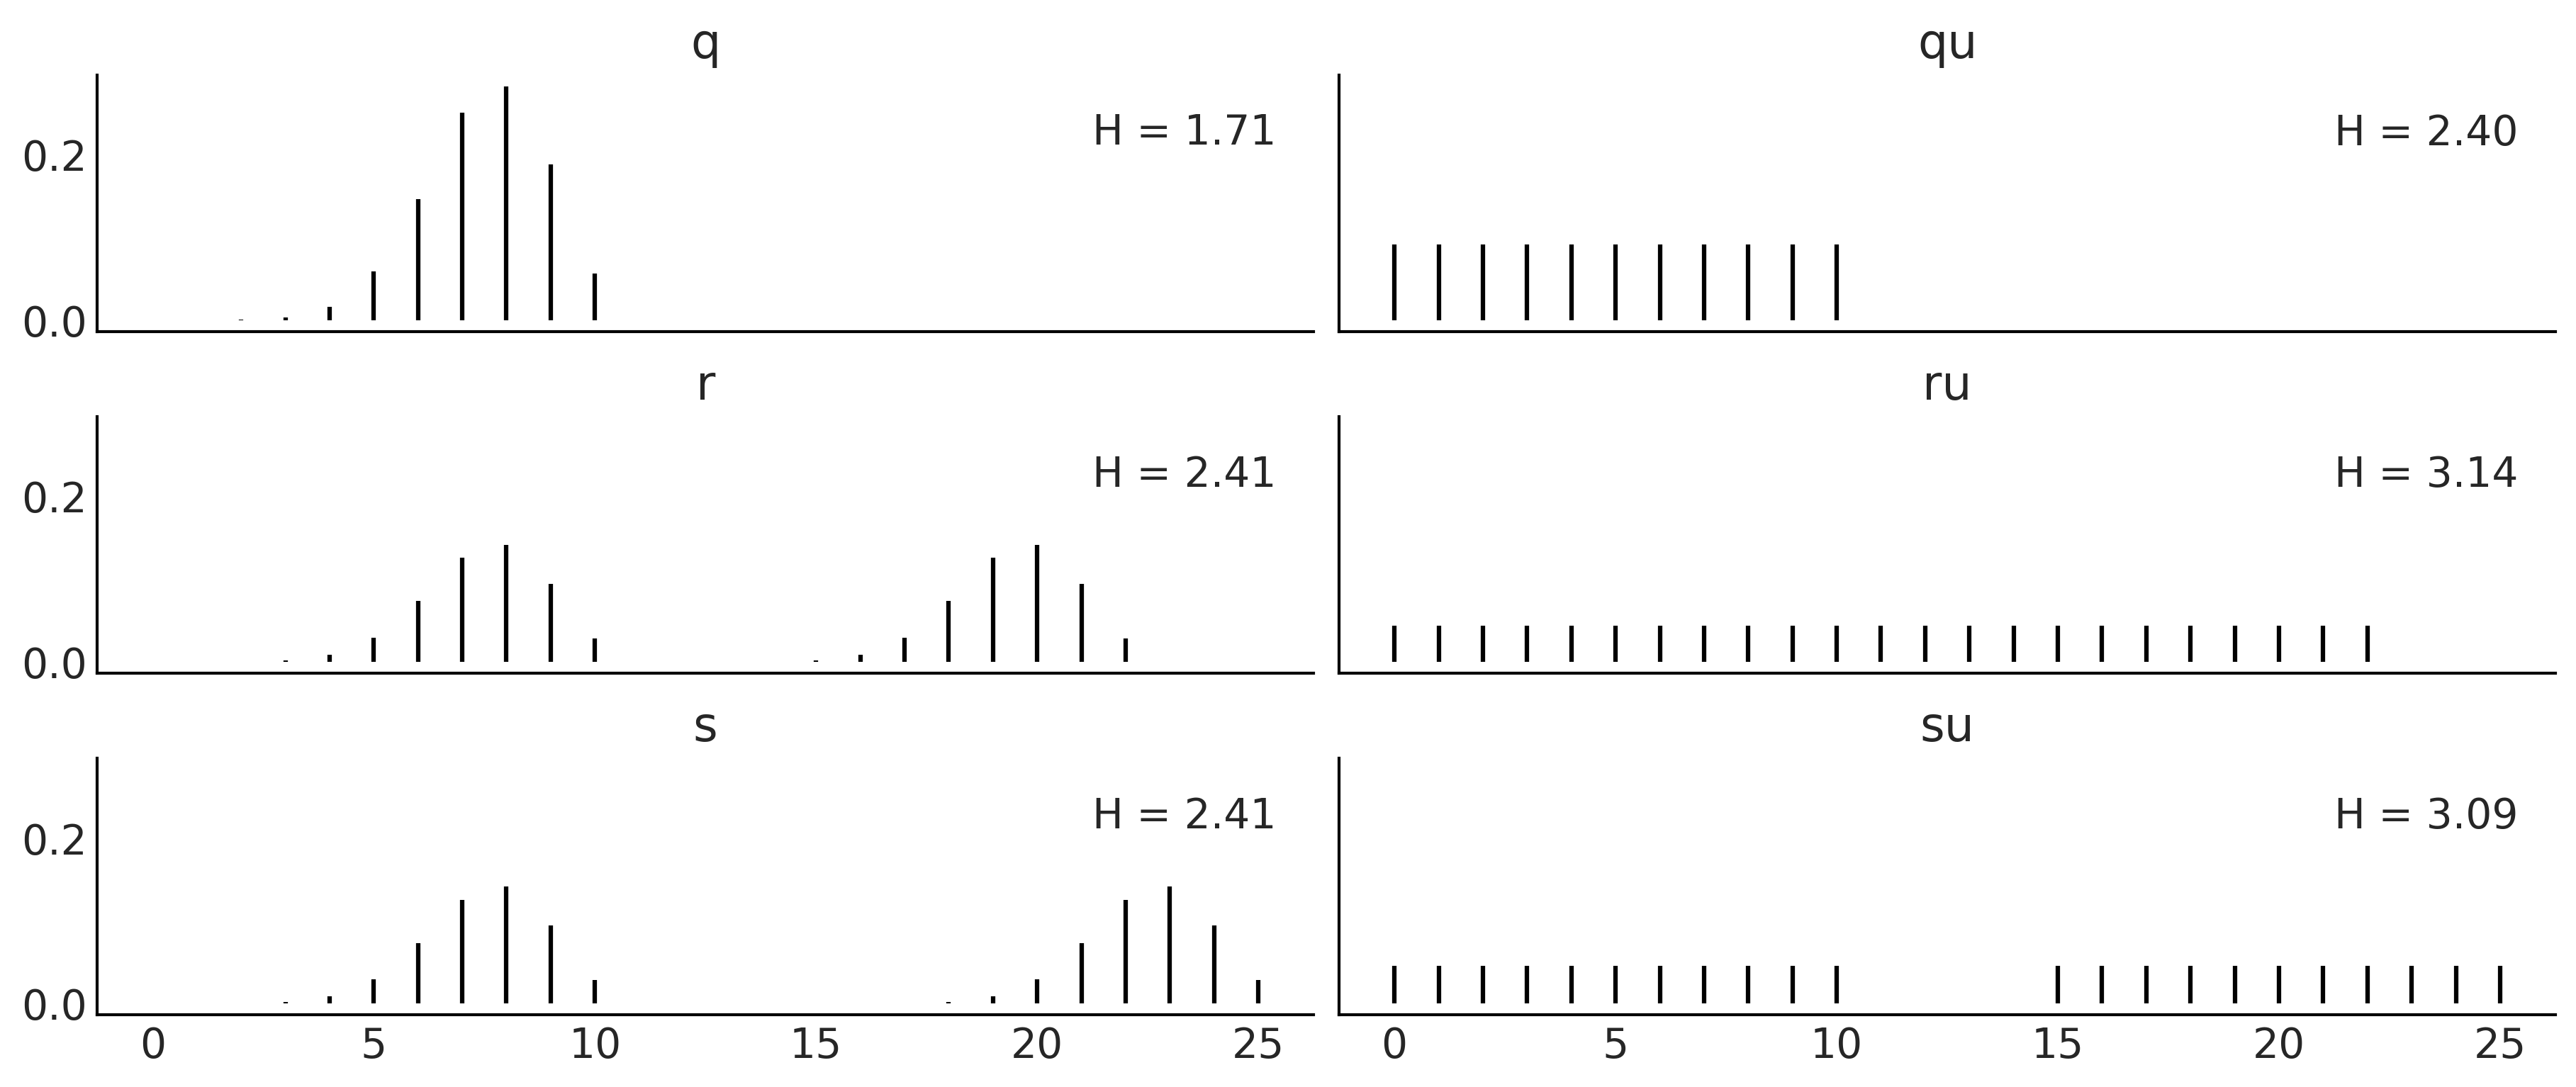

In [8]:
x = range(0, 26)
q_pmf = stats.binom(10, 0.75).pmf(x)
qu_pmf = stats.randint(0, np.max(np.nonzero(q_pmf))+1).pmf(x)
r_pmf = (q_pmf + np.roll(q_pmf, 12)) / 2
ru_pmf = stats.randint(0, np.max(np.nonzero(r_pmf))+1).pmf(x)
s_pmf = (q_pmf + np.roll(q_pmf, 15)) / 2
su_pmf = (qu_pmf + np.roll(qu_pmf, 15)) / 2

_, ax = plt.subplots(3, 2, figsize=(12, 5), sharex=True, sharey=True,
                     constrained_layout=True)
ax = np.ravel(ax)

zipped = zip([q_pmf, qu_pmf, r_pmf, ru_pmf, s_pmf, su_pmf],
             ["q", "qu", "r", "ru", "s", "su"])
for idx, (dist, label) in enumerate(zipped):
    ax[idx].vlines(x, 0, dist, label=f"H = {stats.entropy(dist):.2f}")
    ax[idx].set_title(label)
    ax[idx].legend(loc=1, handlelength=0)

plt.savefig('img/chp11/entropy.png')

## Kullback-Leibler Divergence

### Code 11.6 and Figure 11.23

/tmp/ipykernel_29725/3750536694.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap()


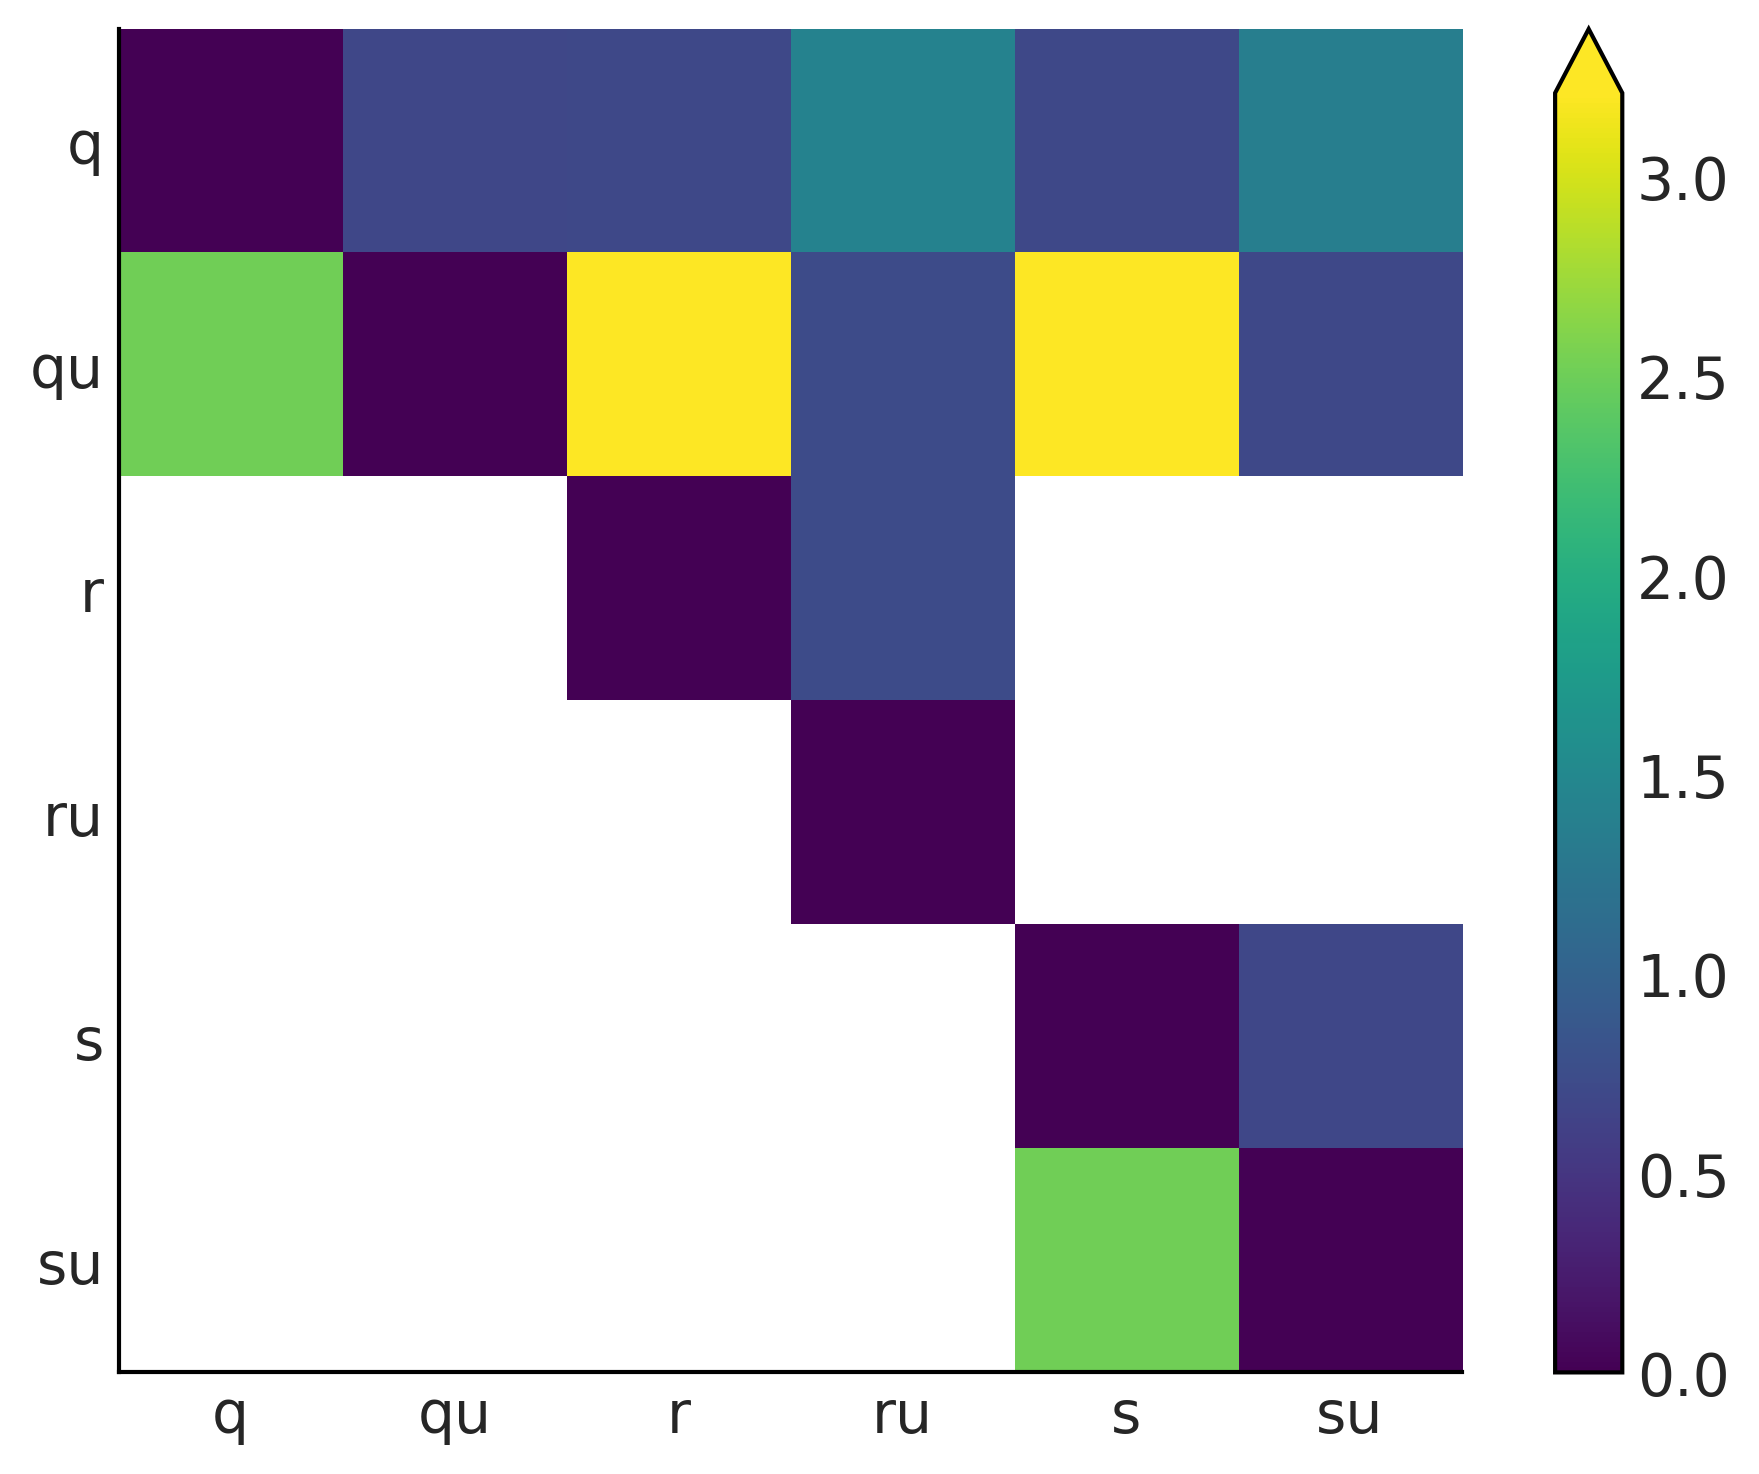

In [9]:
dists = [q_pmf, qu_pmf, r_pmf, ru_pmf, s_pmf, su_pmf]
names = ["q", "qu", "r", "ru", "s", "su"]

fig, ax = plt.subplots()
KL_matrix = np.zeros((6, 6))
for i, dist_i in enumerate(dists):
    for j, dist_j in enumerate(dists):
        KL_matrix[i, j] = stats.entropy(dist_i, dist_j)

ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.set_cmap("viridis")
cmap = plt.cm.get_cmap()
cmap.set_bad('w', 0.3)
im = ax.imshow(KL_matrix)
fig.colorbar(im, extend="max");

plt.savefig("img/chp11/KL_heatmap.png")

In [10]:
def beta_binom(prior, y):
    """
    Compute the marginal-log-likelihood for a beta-binomial model,
    analytically.

    prior : tuple
        tuple of alpha and beta parameter for the prior (beta distribution)
    y : array
        array with "1" and "0" corresponding to the success and fails respectively
    """
    α, β = prior
    success = np.sum(y)
    trials = len(y)
    return np.log(binom(trials, success)) + betaln(α + success, β+trials-success) - betaln(α, β)

In [11]:
def beta_binom_harmonic(prior, y, s=10000):
    """
    Compute the marginal-log-likelihood for a beta-binomial model,
    using the harmonic mean estimator.

    prior : tuple
        tuple of alpha and beta parameter for the prior (beta distribution)
    y : array
        array with "1" and "0" corresponding to the success and fails respectively
    s : int
        number of samples from the posterior
    """
    α, β = prior
    success = np.sum(y)
    trials = len(y)
    posterior_samples = stats.beta(α + success, β+trials-success).rvs(s)
    log_likelihood = stats.binom.logpmf(success, trials, posterior_samples)
    return 1/np.mean(1/log_likelihood)

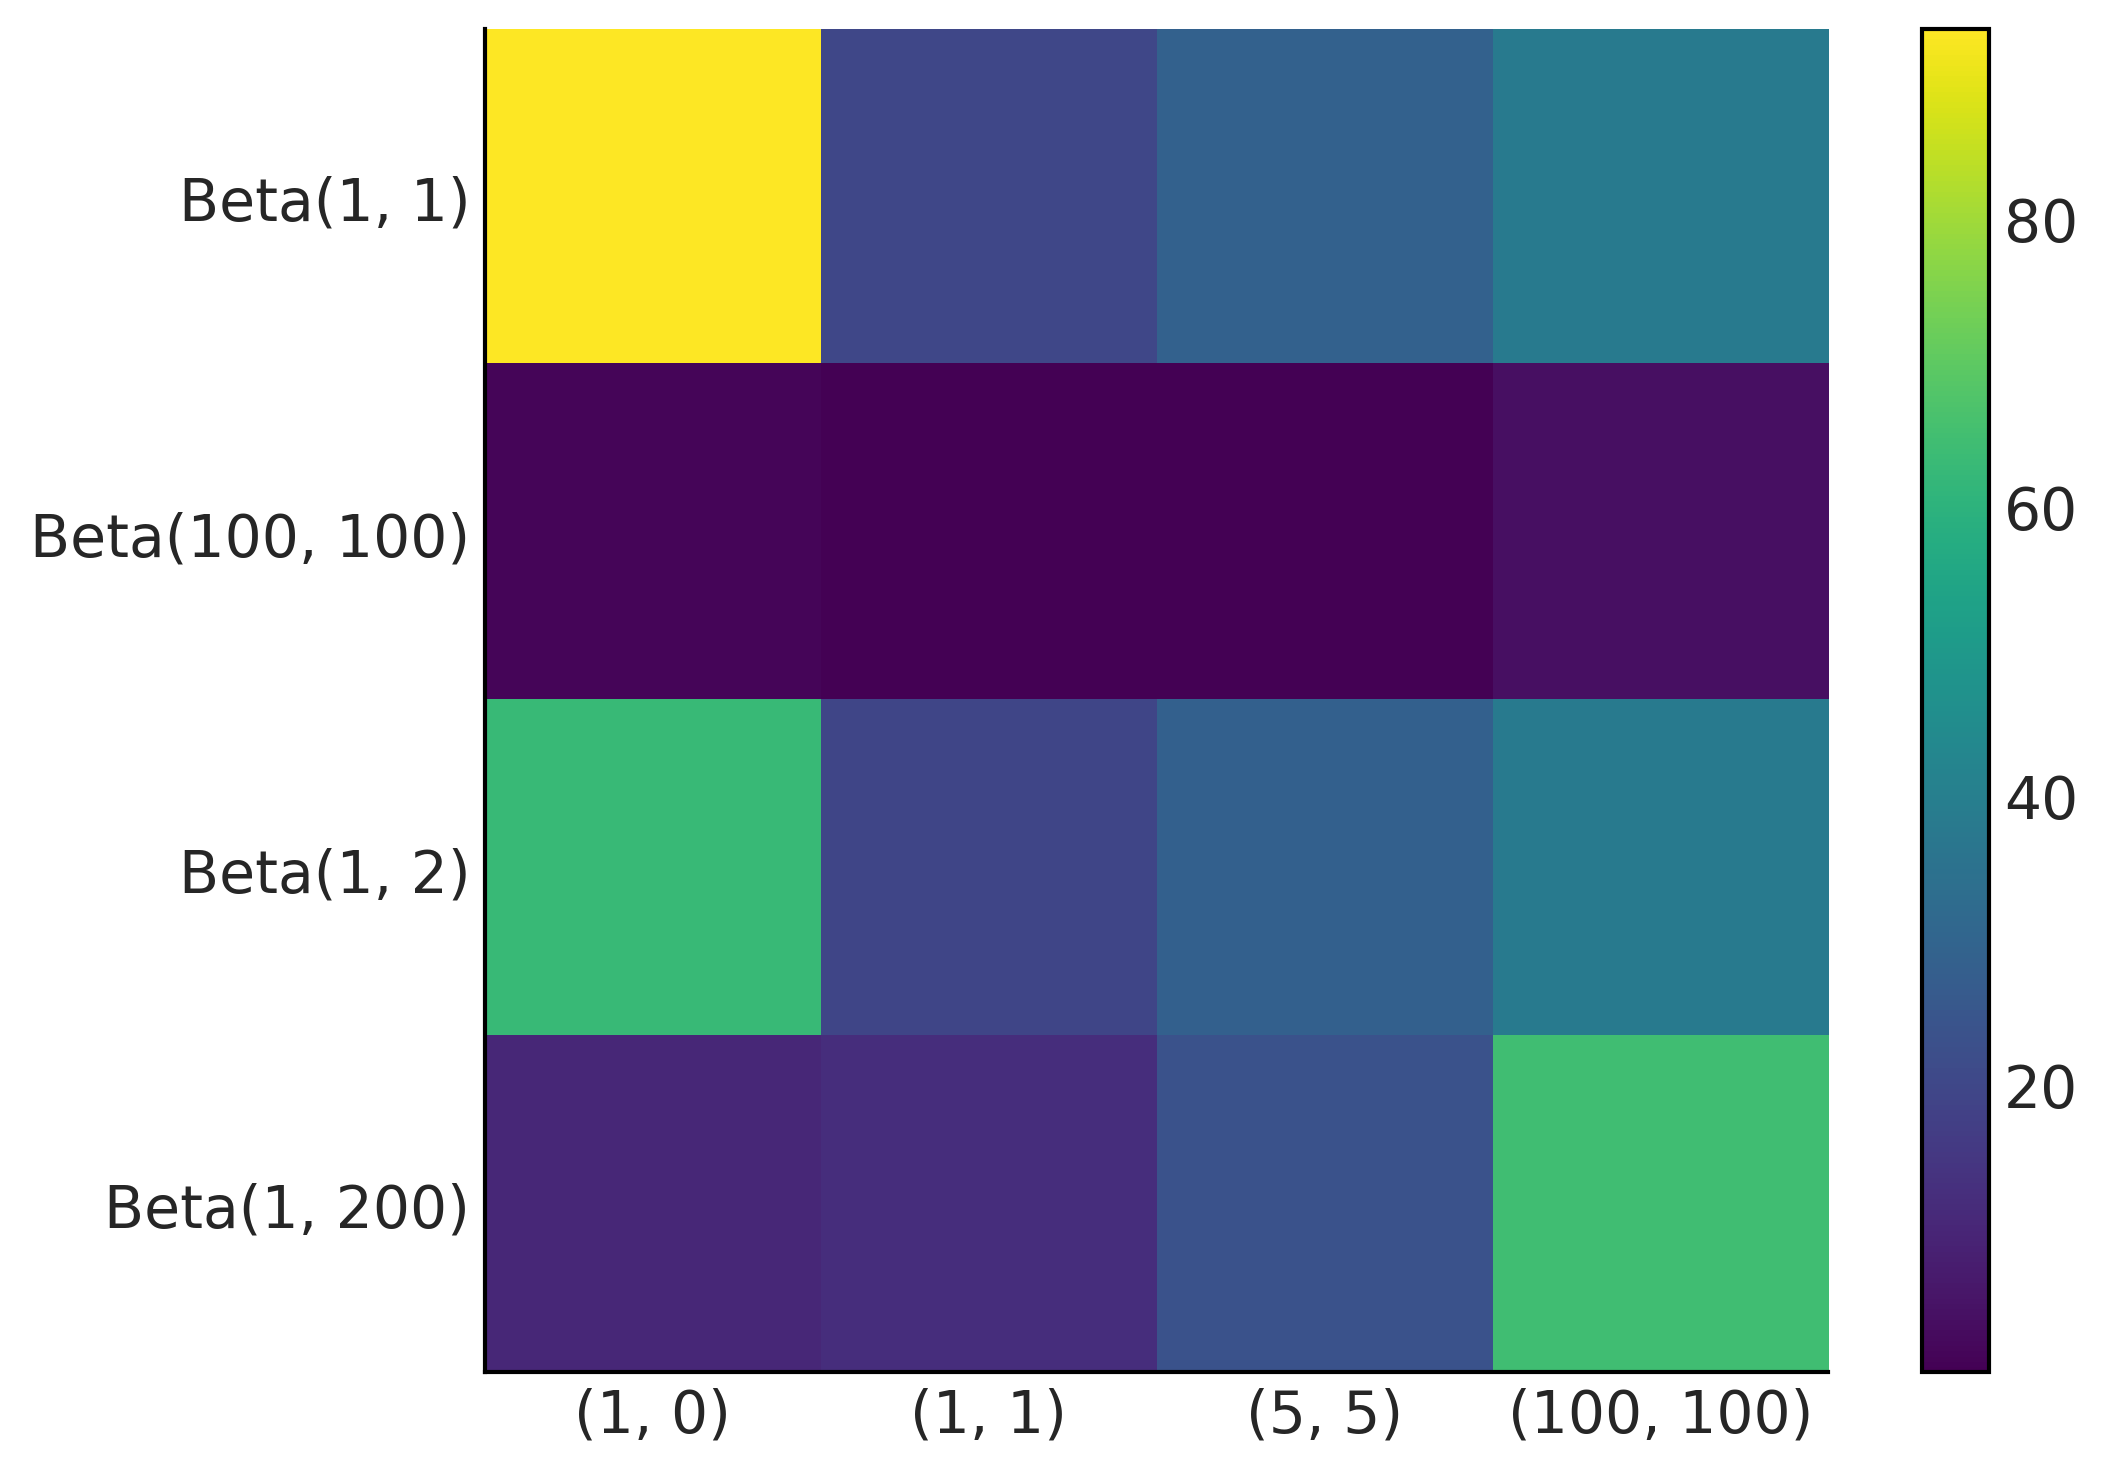

In [12]:
data = [np.repeat([1, 0], rep)
        for rep in ((1, 0), (1, 1), (5, 5), (100, 100))]
priors = ((1, 1), (100, 100), (1, 2), (1, 200))

x_names = [repr((sum(x), len(x)-sum(x))) for x in data]
y_names = ["Beta" + repr(x) for x in priors]

fig, ax = plt.subplots()
error_matrix = np.zeros((len(priors), len(data)))
for i, prior in enumerate(priors):
    for j, y in enumerate(data):
        error_matrix[i, j] = 100 * \
            (1 - (beta_binom_harmonic(prior, y) / beta_binom(prior, y)))
im = ax.imshow(error_matrix, cmap='viridis')
ax.set_xticks(np.arange(len(x_names)))
ax.set_yticks(np.arange(len(y_names)))
ax.set_xticklabels(x_names)
ax.set_yticklabels(y_names)
fig.colorbar(im)
plt.savefig("img/chp11/harmonic_mean_heatmap.png")

In [13]:
def normal_harmonic(sd_0, sd_1, y, s=10000):
    post_tau = 1/sd_0**2 + 1/sd_1**2
    posterior_samples = stats.norm(loc=(y/sd_1**2)/post_tau, scale=(1/post_tau)**0.5).rvs((s, len(x)))
    log_likelihood = stats.norm.logpdf(loc=x, scale=sd_1, x=posterior_samples).sum(1)
    return 1/np.mean(1/log_likelihood)

In [14]:
σ_0 = 1
σ_1 = 1
y = np.array([0])
stats.norm.logpdf(loc=0, scale=(σ_0**2+σ_1**2)**0.5, x=y).sum()

-1.2655121234846454

In [15]:
def posterior_ml_ic_normal(σ_0=1, σ_1=1, y=[1]):
    n = len(y)
    var_μ = 1/((1/σ_0**2) + (n/σ_1**2))
    μ = var_μ * np.sum(y)/σ_1**2
    σ_μ = var_μ**0.5

    posterior = stats.norm(loc=μ, scale=σ_μ)
    samples = posterior.rvs(size=(2, 1000))
    log_likelihood = stats.norm(loc=samples[:, :, None], scale=σ_1).logpdf(y)
    idata = az.from_dict(log_likelihood={'o': log_likelihood})

    log_ml = stats.norm.logpdf(loc=0, scale=(σ_0**2+σ_1**2)**0.5, x=y).sum()
    
    x = np.linspace(-5, 6, 300)
    density = posterior.pdf(x)
    
    return μ, σ_μ, x, density, log_ml, az.waic(idata).elpd_waic, az.loo(idata, reff=1).elpd_loo

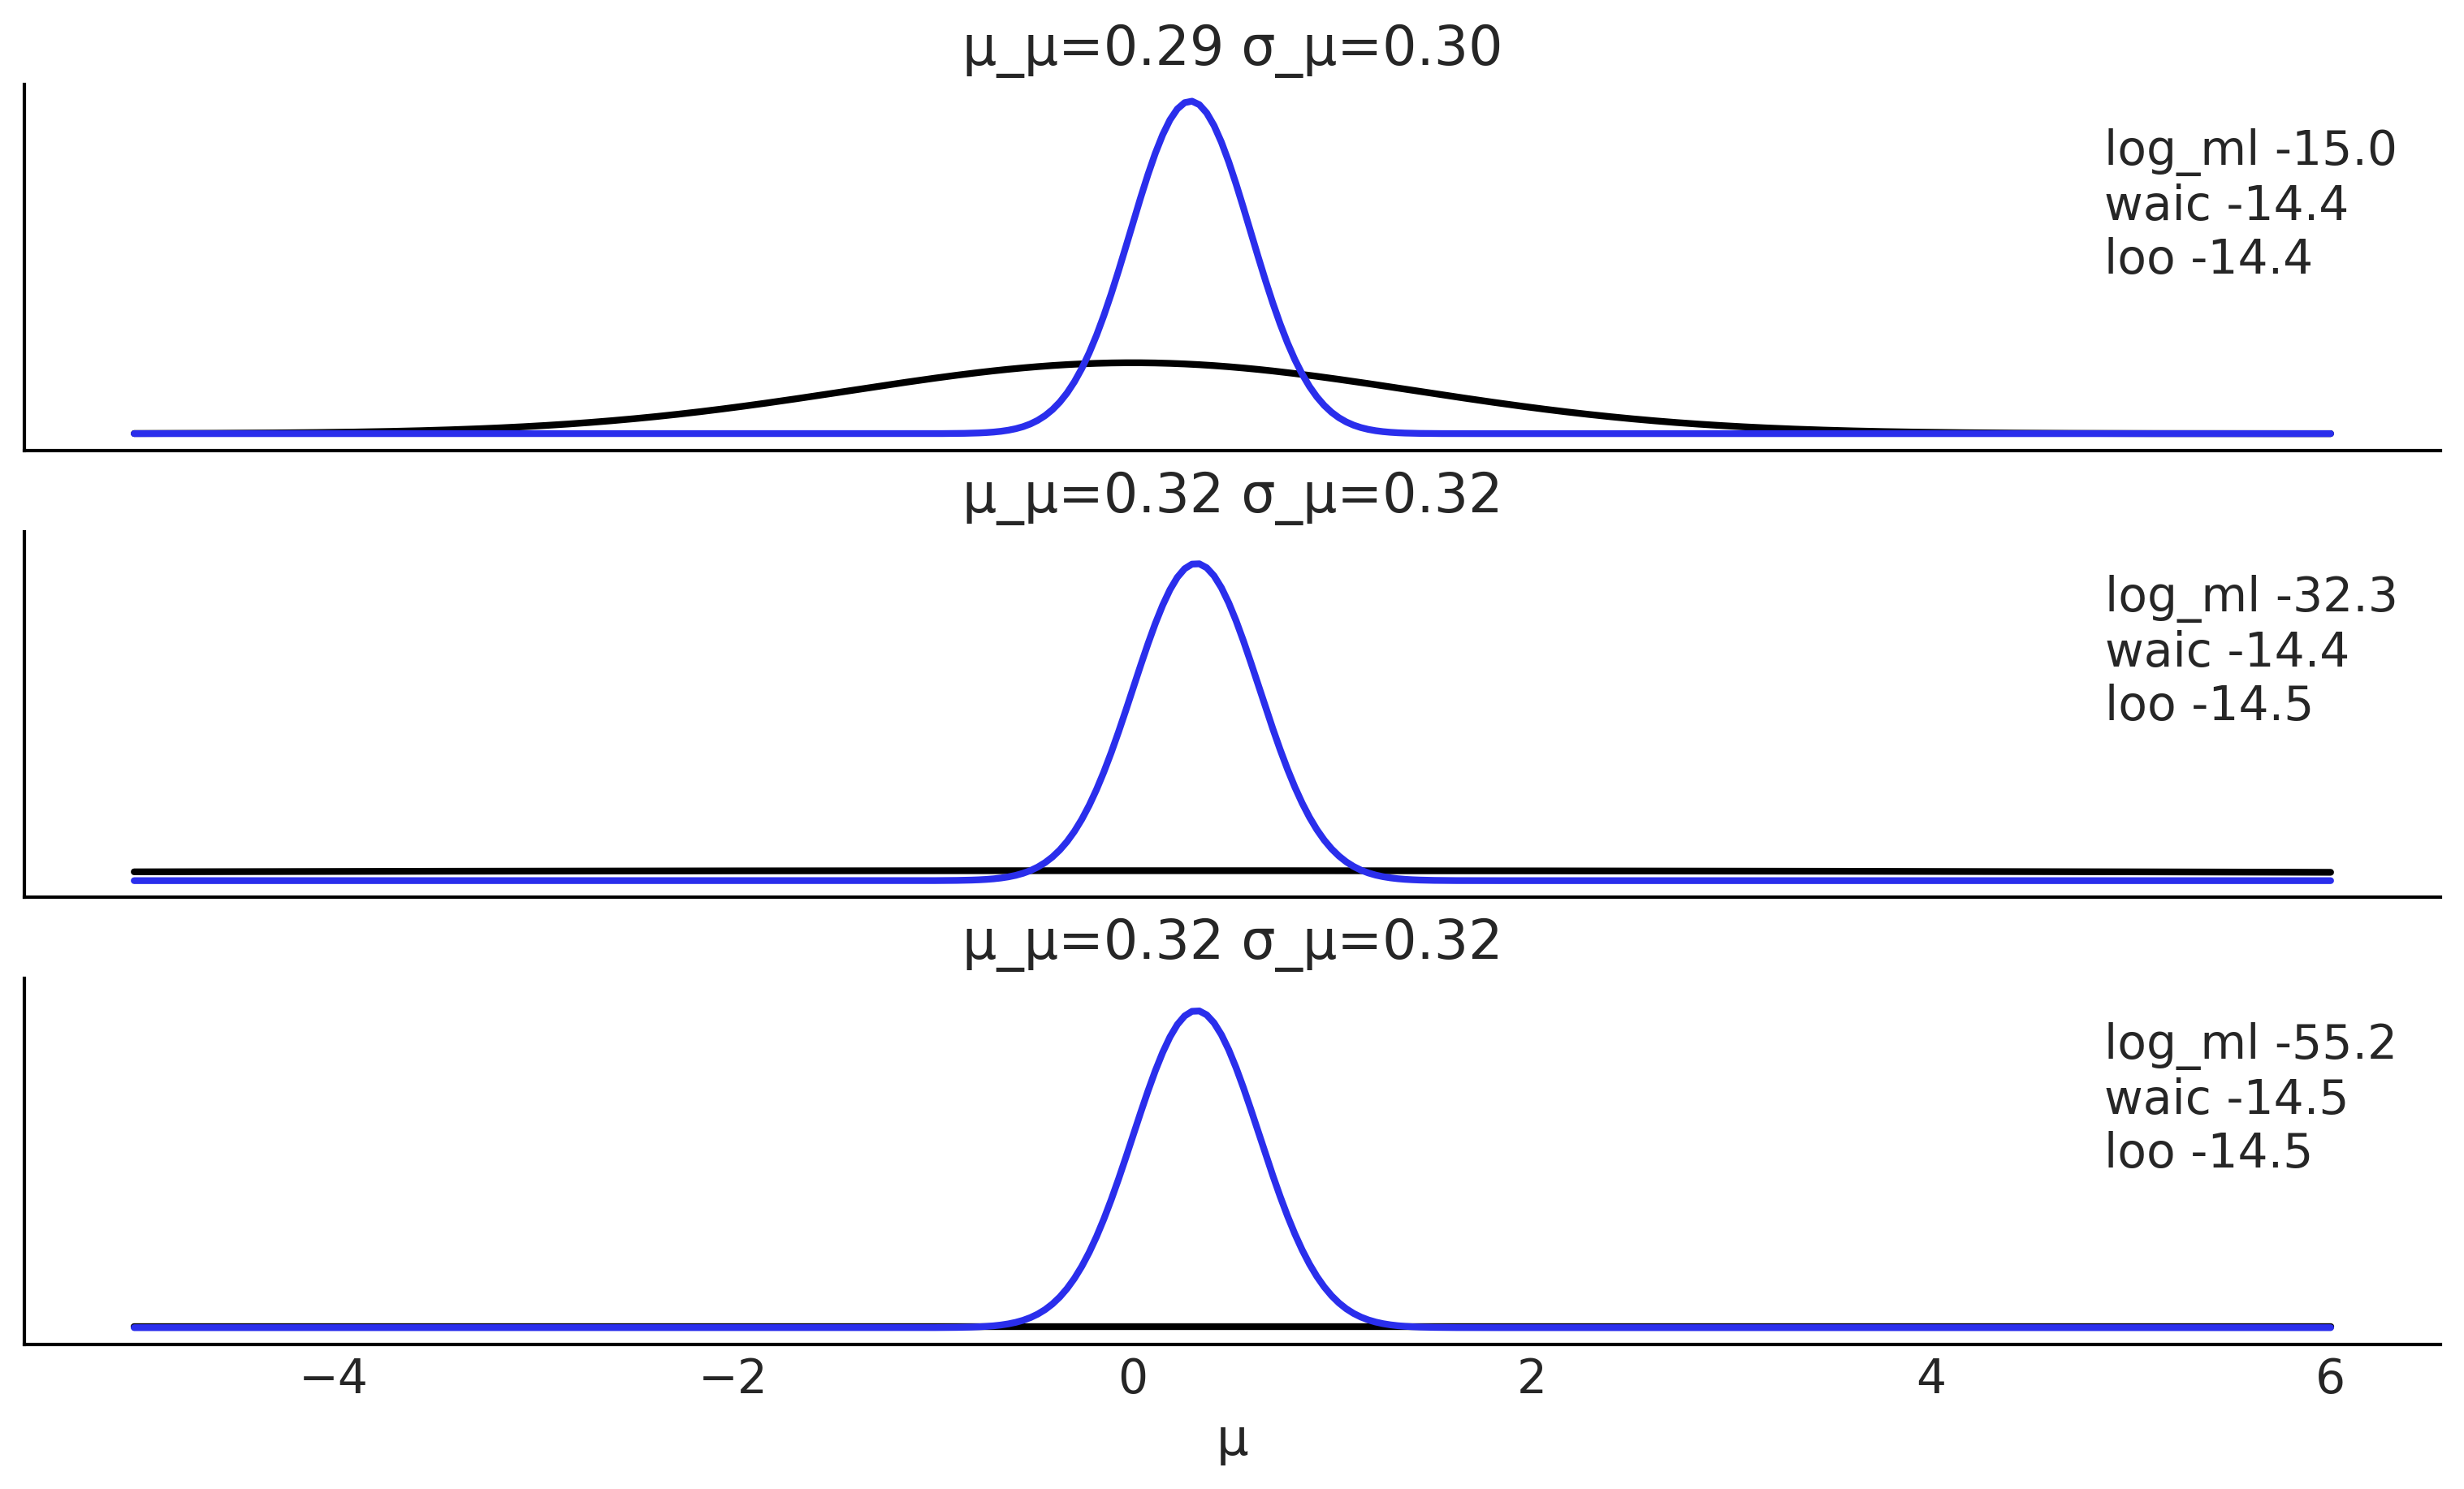

In [16]:
y = np.array([ 0.65225338, -0.06122589,  0.27745188,  1.38026371, -0.72751008,
              -1.10323829,  2.07122286, -0.52652711,  0.51528113,  0.71297661])

_, ax = plt.subplots(3, figsize=(10, 6), sharex=True, sharey=True,
                     constrained_layout=True)

for i, σ_0 in enumerate((1, 10, 100)):
    μ_μ, σ_μ, x, density, log_ml, waic, loo = posterior_ml_ic_normal(σ_0, σ_1, y)
    ax[i].plot(x, stats.norm(loc=0, scale=(σ_0**2+σ_1**2)**0.5).pdf(x), lw=2)
    ax[i].plot(x, density, lw=2, color='C4')
    ax[i].plot(0, label=f'log_ml {log_ml:.1f}\nwaic {waic:.1f}\nloo {loo:.1f}\n', alpha=0)
    ax[i].set_title(f'μ_μ={μ_μ:.2f} σ_μ={σ_μ:.2f}')
    ax[i].legend()
ax[2].set_yticks([])

ax[2].set_xlabel("μ")

plt.savefig("img/chp11/ml_waic_loo.png")

In [17]:
σ_0 = 1
σ_1 = 1
y = np.array([0])
stats.norm.logpdf(loc=0, scale=(σ_0**2 + σ_1**2)**0.5, x=y).sum()

-1.2655121234846454

In [18]:
N = 10000
x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2) <= 1
pi = inside.sum()*4/N
error = abs((pi - np.pi) / pi) * 100

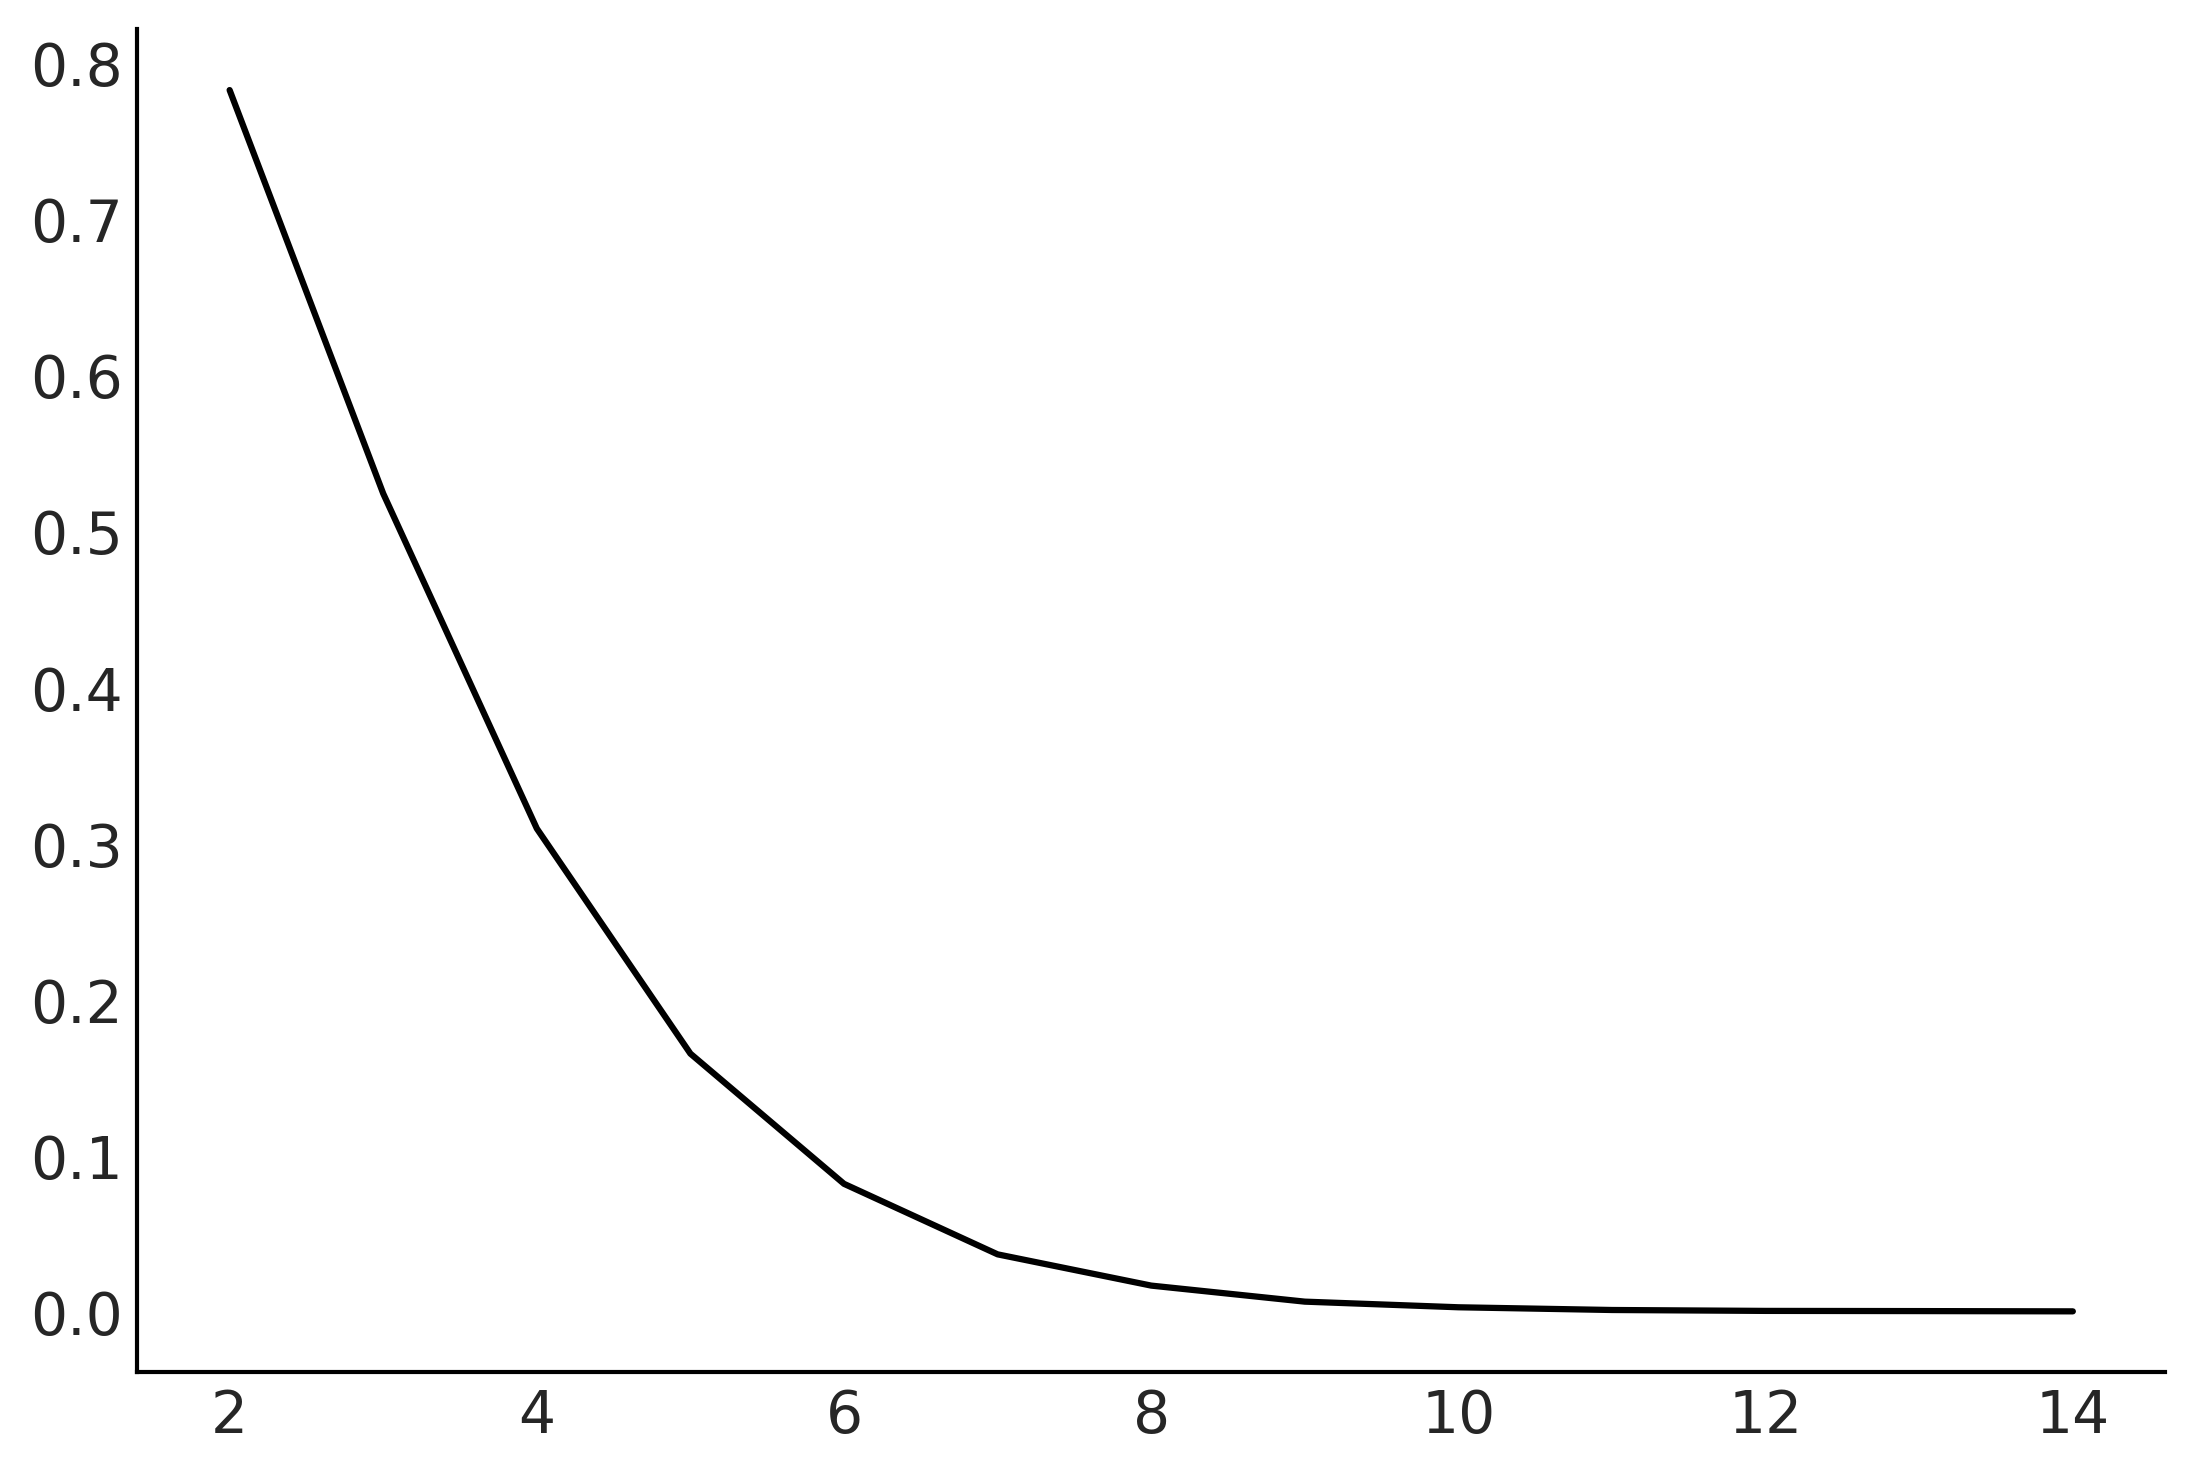

In [19]:
total = 100000

dims = []
prop = []
for d in range(2, 15):
    x = np.random.random(size=(d, total))
    inside = ((x * x).sum(axis=0) < 1).sum()
    dims.append(d)
    prop.append(inside / total)
    
plt.plot(dims, prop);

In [20]:
def posterior_grid(ngrid=10, α=1, β=1, heads=6, trials=9):
    grid = np.linspace(0, 1, ngrid)
    prior = stats.beta(α, β).pdf(grid)
    likelihood = stats.binom.pmf(heads, trials, grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    return posterior

### Variational Inference

See https://blog.tensorflow.org/2021/02/variational-inference-with-joint-distributions-in-tensorflow-probability.html for a more extended examples

In [21]:
# az.style.use("arviz-colors")

# import tensorflow as tf
# import tensorflow_probability as tfp

# tfd = tfp.distributions

In [22]:
# # An arbitrary density function as target
# target_logprob = lambda x, y: -(1.-x)**2 - 1.5*(y - x**2)**2

# # Set up two different surrogate posterior distribution
# event_shape = [(), ()]  # theta is 2 scalar
# mean_field_surrogate_posterior = tfp.experimental.vi.build_affine_surrogate_posterior(
#     event_shape=event_shape, operators="diag")
# full_rank_surrogate_posterior = tfp.experimental.vi.build_affine_surrogate_posterior(
#     event_shape=event_shape, operators="tril")

# # Optimization
# losses = []
# posterior_samples = []
# for approx in [mean_field_surrogate_posterior, full_rank_surrogate_posterior]:
#     loss = tfp.vi.fit_surrogate_posterior(
#         target_logprob, approx, num_steps=200, optimizer=tf.optimizers.Adam(0.1),
#         sample_size=5)
#     losses.append(loss)
#     # The approx is a tfp distribution, we can sample from it after training
#     posterior_samples.append(approx.sample(10000))

In [23]:
# plt.plot(np.asarray(losses).T)
# plt.legend(['mean-field', 'full-rank']);

### Figure 11.33

In [24]:
# grid = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-2, 5, 100))
# Z = - target_logprob(*grid)

# _, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
# for ax, approx, name in zip(
#     axes,
#     [mean_field_surrogate_posterior, full_rank_surrogate_posterior],
#     ["Mean-field Approximation", "Full-rank Approximation"]):
#     ax.contour(*grid, Z, levels=np.arange(7))
#     ax.plot(*approx.sample(10000), ".", alpha=.1)
#     ax.set_title(name)
# plt.tight_layout();

# plt.savefig("img/chp11/vi_in_tfp.png")

## VI Deep dive

In [25]:
# tfb = tfp.bijectors

In [26]:
# event_shape = [(), ()]
# full_rank_surrogate_posterior = tfp.experimental.vi.build_affine_surrogate_posterior(
#     event_shape=event_shape, operators="tril")

# # mean_field_surrogate_posterior = tfp.experimental.vi.build_affine_surrogate_posterior(
# #     event_shape=event_shape, operators="diag")
# mean_field_surrogate_posterior = tfd.JointDistributionSequential([
#     tfd.Normal(tf.Variable(0.), tfp.util.TransformedVariable(1., bijector=tfb.Exp())),
#     tfd.Normal(tf.Variable(0.), tfp.util.TransformedVariable(1., bijector=tfb.Exp())),
# ])

# # Density estimation with MADE.
# made = tfb.AutoregressiveNetwork(params=2, hidden_units=[10, 10])
# flow_surrogate_posterior = tfd.TransformedDistribution(
#     distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[2]),
#     bijector=tfb.Chain([
#         tfb.JointMap([tfb.Reshape([]), tfb.Reshape([])]),
#         tfb.Split([1, 1]),
#         tfb.MaskedAutoregressiveFlow(made)
#     ]))
# # Create a Masked Autoregressive Flow bijector.
# # prior = tfd.JointDistributionSequential([tfd.Normal(0., 1.), tfd.Normal(0., 1.)])
# # maf = tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=net)
# # flow_surrogate_posterior = tfp.experimental.vi.build_split_flow_surrogate_posterior(
# #     event_shape=prior.event_shape_tensor(), trainable_bijector=maf)

# # Optimization
# losses = []
# posterior_samples = []
# for approx in [mean_field_surrogate_posterior, full_rank_surrogate_posterior, flow_surrogate_posterior]:
#     loss = tfp.vi.fit_surrogate_posterior(
#         target_logprob, approx, num_steps=200, optimizer=tf.optimizers.Adam(0.1),
#         sample_size=5)
#     losses.append(loss)
#     # The approx is a tfp distribution, we can sample from it after training
#     posterior_samples.append(approx.sample(10000))

In [27]:
# plt.plot(np.asarray(losses).T)
# plt.legend(['mean-field', 'full-rank', 'flow']);

In [28]:
# grid = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-2, 5, 100))
# Z = - target_logprob(*grid)

# _, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
# for ax, approx, name in zip(
#     axes,
#     [mean_field_surrogate_posterior, full_rank_surrogate_posterior, flow_surrogate_posterior],
#     ["Mean-field Approximation", "Full-rank Approximation", "Flow Approximation"]):
#     ax.contour(*grid, Z, levels=np.arange(7))
#     ax.plot(*approx.sample(10000), ".", alpha=.1)
#     ax.set_title(name)
# plt.tight_layout();